# Torch

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install "colorama"

import torch
#use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cpu' # 'cuda' or 'cpu'

# Download Dataset GTEA61

In [ ]:
import os
import sys, os

#1YKfdhB9Xxh4pmND1V3gcm3Gyjc8v8idq
if not os.path.isfile('/content/GTEA61.zip'):
  !gdown --id 1Z5RWA8yKIy0PvxMlScV-aAz22ITtivfk # 3-5 min
  !jar xvf  "/content/GTEA61.zip"
  # !unzip  "/content/drive/MyDrive/Colab Notebooks/datasets/GTEA61.zip" -d "/content/"

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):
  !gdown 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 # 3-5 min



# Download Code

In [3]:
!git clone "https://github.com/plana93/Homework_AIML.git"
#!rm -r "/content/Homework_AIML"

Cloning into 'Homework_AIML'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (78/78), 734.41 KiB | 29.38 MiB/s, done.
Resolving deltas: 100% (36/36), done.




# Import Code


In [2]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torchvision
from colorama import init
from colorama import Fore, Back, Style

from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

# used for the Class Activation Map
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("/content/Homework_AIML/")
import Homework_AIML
from Homework_AIML import *

from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from spatial_transforms import (
    Compose,
    ToTensor,
    CenterCrop,
    Scale,
    Normalize,
    MultiScaleCornerCrop,
    RandomHorizontalFlip,
)

# MAIN PARAMs

In [3]:
# homework_step = 0 #--> Learning without Temporal information (avgpool)
# homework_step = 1 #--> Learning with Temporal information (LSTM)
homework_step = 2  # --> Learning with Spatio-Temporal information (ConvLSTM)


DATA_DIR = '/content/GTEA61/'  # path dataset
model_folder = '/content/saved_models/' + "homework_step" + str(homework_step) + "/"  # path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)


# All this params can be changed!

NUM_CLASSES = 61
BATCH_SIZE = 64
LR = 0.001  # The initial Learning Rate
MOMENTUM = 0.9  # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 4e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 200  # Total number of training epochs (iterations over dataset)
STEP_SIZE = [25, 75, 150]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1  # Multiplicative factor for learning rate step-down
MEM_SIZE = 512  # Dim of internal state of LSTM or ConvLSTM
SEQ_LEN = 3  # Num Frames

# this dictionary is needed for the logger class
parameters = {
    'DEVICE': DEVICE,
    'NUM_CLASSES': NUM_CLASSES,
    'BATCH_SIZE': BATCH_SIZE,
    'LR': LR,
    'MOMENTUM': MOMENTUM,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'NUM_EPOCHS': NUM_EPOCHS,
    'STEP_SIZE': STEP_SIZE,
    'GAMMA': GAMMA,
    'MEM_SIZE': MEM_SIZE,
    'SEQ_LEN': SEQ_LEN,
}

# Dataloaders & Preprocessing

In [4]:
# Normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = Normalize(mean=mean, std=std)
spatial_transform = Compose(
    [Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224), ToTensor(), normalize]
)
spatial_transform_val = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])

In [5]:
# Prepare Pytorch train/test Datasets
train_dataset = GTEA61(DATA_DIR, split='train', transform=spatial_transform, seq_len=SEQ_LEN)
test_dataset = GTEA61(DATA_DIR, split='test', transform=spatial_transform_val, seq_len=SEQ_LEN)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

['S1', 'S3', 'S2', 'S4']
['S1', 'S3', 'S2', 'S4']
Train Dataset: 341
Test Dataset: 116


#Model

In [6]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable


# LSTM
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_i_hx = nn.Linear(input_size, hidden_size)
        self.W_i_hh = nn.Linear(hidden_size, hidden_size)

        self.W_f_hx = nn.Linear(input_size, hidden_size)
        self.W_f_hh = nn.Linear(hidden_size, hidden_size)

        self.W_o_hx = nn.Linear(input_size, hidden_size)
        self.W_o_hh = nn.Linear(hidden_size, hidden_size)

        self.W_g_hx = nn.Linear(input_size, hidden_size)
        self.W_g_hh = nn.Linear(hidden_size, hidden_size)

        self.sigmoid = F.sigmoid
        self.tanh = F.tanh

        torch.nn.init.xavier_normal_(self.W_i_hx.weight)
        torch.nn.init.constant_(self.W_i_hx.bias, 0)
        torch.nn.init.xavier_normal_(self.W_i_hh.weight)

        torch.nn.init.xavier_normal_(self.W_f_hx.weight)
        torch.nn.init.constant_(self.W_f_hx.bias, 0)
        torch.nn.init.xavier_normal_(self.W_f_hh.weight)

        torch.nn.init.xavier_normal_(self.W_o_hx.weight)
        torch.nn.init.constant_(self.W_o_hx.bias, 0)
        torch.nn.init.xavier_normal_(self.W_o_hh.weight)

        torch.nn.init.xavier_normal_(self.W_g_hx.weight)
        torch.nn.init.constant_(self.W_g_hx.bias, 0)
        torch.nn.init.xavier_normal_(self.W_g_hh.weight)

    def forward(self, x, state):
        if state is None:
            state = (
                Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                Variable(torch.randn(x.size(0), x.size(1)).cuda()),
            )

        # extract c_{t-1} and h_{t-1}
        c_t_1, h_t_1 = state
        # h_t_1, c_t_1 = state

        i = self.sigmoid(self.W_i_hx(x) + self.W_i_hh(h_t_1))
        f = self.sigmoid(self.W_f_hx(x) + self.W_f_hh(h_t_1))
        o = self.sigmoid(self.W_o_hx(x) + self.W_o_hh(h_t_1))
        g = self.tanh(self.W_g_hx(x) + self.W_g_hh(h_t_1))

        c_t = f * c_t_1 + i * g
        h_t = o * self.tanh(c_t)

        return c_t, h_t
        # return h_t, c_t


# ConvLSTM
class MyConvLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=3, stride=1, padding=1):
        super(MyConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv_i_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_i_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.conv_f_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_f_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.conv_c_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.conv_o_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_o_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.sigmoid = F.sigmoid
        self.tanh = F.tanh

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

    def forward(self, x, state):
        if state is None:
            state = (
                Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()),
                Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()),
            )

        # extract c_{t-1} and h_{t-1}
        # c_t_1, h_t_1 = state
        h_t_1, c_t_1 = state

        i = self.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(h_t_1))
        f = self.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(h_t_1))
        o = self.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(h_t_1))
        g = self.tanh(self.conv_c_xx(x) + self.conv_c_hh(h_t_1))

        c_t = f * c_t_1 + i * g
        h_t = o * self.tanh(c_t)

        # return c_t, h_t
        return h_t, c_t


# Network
class ourModel(nn.Module):
    def __init__(self, num_classes=61, mem_size=512, homework_step=0, DEVICE=""):
        super(ourModel, self).__init__()
        self.DEVICE = DEVICE
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.homework_step = homework_step
        if self.homework_step == 1:
            self.lstm_cell = MyLSTMCell(512, mem_size)
        elif self.homework_step == 2:
            self.lstm_cell = MyConvLSTMCell(512, mem_size)

        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)

    def forward(self, inputVariable):
        # Learning without Temporal information (mean)
        if self.homework_step == 0:
            # inputVariable: (Frames, BS, C, W, H)
            video_level_features = torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE)
            for t in range(inputVariable.size(0)):
                # spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                # frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(spatial_frame_feat.size(0), -1)
                video_level_features = video_level_features + frame_feat

            video_level_features = video_level_features / inputVariable.size(0)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        # Learning with Temporal information (LSTM)
        elif self.homework_step == 1:
            # inputVariable: (Frames, BS, C, W, H)
            state = (
                torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),
                torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),
            )
            for t in range(inputVariable.size(0)):
                # spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                # frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(state[1].size(0), -1)
                state = self.lstm_cell(frame_feat, state)

            video_level_features = state[1]
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        # Learning with Temporal information (ConvLSTM)
        elif self.homework_step == 2:
            state = (
                torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
                torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
            )
            for t in range(inputVariable.size(0)):
                # spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                state = self.lstm_cell(spatial_frame_feat, state)
            video_level_features = self.avgpool(state[1]).view(state[1].size(0), -1)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

#Build Model - Loss - Opt

In [7]:
# CUDA_LAUNCH_BLOCKING=1
validate = True

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE)  # model

# Train only the lstm cell and classifier
model.train(False)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)


model = model.to(DEVICE)

model.load_state_dict(
    torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True
)


# Loss
loss_fn = nn.CrossEntropyLoss()
# Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
# Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 309MB/s]


#Training


In [8]:
def train(
    model, train_dataset, test_dataset, train_loader, val_loader, loss_fn, optimizer_fn, optim_scheduler, model_folder
):
    train_iter = 0
    val_iter = 0
    min_accuracy = 0

    trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
    val_samples = len(test_dataset)
    iterPerEpoch = len(train_loader)
    val_steps = len(val_loader)
    cudnn.benchmark
    model_checkpoint = "model"  # name

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        numCorrTrain = 0

        # blocks to train
        if homework_step > 0:
            model.lstm_cell.train(True)
        model.classifier.train(True)

        for i, (inputs, targets) in enumerate(train_loader):
            train_iter += 1
            optimizer_fn.zero_grad()

            # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
            inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
            labelVariable = targets.to(DEVICE)

            # feeds in model
            outputs, _ = model(inputVariable)

            # compute loss
            loss = loss_fn(outputs, labelVariable)

            # backward loss and optimizer step
            loss.backward()
            optimizer_fn.step()

            # compute the training accuracy
            _, predicted = torch.max(outputs.data, 1)
            numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
            step_loss = loss.data.item()
            epoch_loss += step_loss

        avg_loss = epoch_loss / iterPerEpoch
        trainAccuracy = (numCorrTrain / trainSamples) * 100
        # train_logger.add_epoch_data(epoch+1, trainAccuracy, avg_loss)
        print(
            Fore.BLACK
            + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_loss, trainAccuracy)
        )
        if validate:
            if (epoch + 1) % 1 == 0:
                model.train(False)
                val_loss_epoch = 0
                numCorr = 0
                for j, (inputs, targets) in enumerate(val_loader):
                    val_iter += 1
                    inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                    labelVariable = targets.to(DEVICE)

                    outputs, _ = model(inputVariable)
                    val_loss = loss_fn(outputs, labelVariable)
                    val_loss_step = val_loss.data.item()
                    val_loss_epoch += val_loss_step
                    _, predicted = torch.max(outputs.data, 1)
                    numCorr += torch.sum(predicted == labelVariable.data).data.item()
                    # val_logger.add_step_data(val_iter, numCorr, val_loss_step)

                val_accuracy = (numCorr / val_samples) * 100
                avg_val_loss = val_loss_epoch / val_steps

                print(
                    Fore.GREEN
                    + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy)
                )
                if val_accuracy > min_accuracy:
                    print("[||| NEW BEST on val||||]")
                    save_path_model = os.path.join(model_folder, model_checkpoint)
                    torch.save(model.state_dict(), save_path_model)
                    min_accuracy = val_accuracy

        optim_scheduler.step()

    print(Fore.CYAN + "Best Acc --> ", min_accuracy)
    print(Fore.CYAN + "Last Acc --> ", val_accuracy)

#Test

In [9]:
def test(model, test_dataset, val_loader, loss_fn):
    model.train(False)
    val_loss_epoch = 0
    numCorr = 0
    val_iter = 0
    val_samples = len(test_dataset)
    val_steps = len(val_loader)

    with torch.no_grad():
        for j, (inputs, targets) in enumerate(val_loader):
            val_iter += 1
            inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
            labelVariable = targets.to(DEVICE)

            outputs, _ = model(inputVariable)
            val_loss = loss_fn(outputs, labelVariable)
            val_loss_step = val_loss.data.item()
            val_loss_epoch += val_loss_step
            _, predicted = torch.max(outputs.data, 1)
            numCorr += torch.sum(predicted == labelVariable.data).data.item()

        val_accuracy = (numCorr / val_samples) * 100
        avg_val_loss = val_loss_epoch / val_steps

    print('Loss {:.3f} | Accuracy = {:.3f}'.format(avg_val_loss, val_accuracy))

# Learning without Temporal information (avgpool)

In [ ]:
train(
    model, train_dataset, test_dataset, train_loader, val_loader, loss_fn, optimizer_fn, optim_scheduler, model_folder
)

Train: Epoch = 1 | Loss = 4.664 | Accuracy = 3.125
Val: Epoch = 1 | Loss 4.136 | Accuracy = 6.034
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.500 | Accuracy = 2.812
Val: Epoch = 2 | Loss 4.060 | Accuracy = 3.448
Train: Epoch = 3 | Loss = 4.456 | Accuracy = 3.438
Val: Epoch = 3 | Loss 4.019 | Accuracy = 1.724
Train: Epoch = 4 | Loss = 4.455 | Accuracy = 4.062
Val: Epoch = 4 | Loss 3.957 | Accuracy = 3.448
Train: Epoch = 5 | Loss = 4.471 | Accuracy = 2.188
Val: Epoch = 5 | Loss 3.901 | Accuracy = 5.172
Train: Epoch = 6 | Loss = 4.338 | Accuracy = 3.125
Val: Epoch = 6 | Loss 3.848 | Accuracy = 6.897
[||| NEW BEST on val||||]
Train: Epoch = 7 | Loss = 4.338 | Accuracy = 5.938
Val: Epoch = 7 | Loss 3.806 | Accuracy = 6.897
Train: Epoch = 8 | Loss = 4.224 | Accuracy = 4.375
Val: Epoch = 8 | Loss 3.770 | Accuracy = 6.034
Train: Epoch = 9 | Loss = 4.121 | Accuracy = 5.000
Val: Epoch = 9 | Loss 3.738 | Accuracy = 7.759
[||| NEW BEST on val||||]
Train: Epoch = 10 | Loss = 4.051 | Accur

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/homework_step0/model'))

test(model, test_dataset, val_loader, loss_fn)

Loss 3.245 | Accuracy = 25.862


#**Learning with Temporal information** (LSTM)

## Classify using $h_t$

In [ ]:
train(
    model, train_dataset, test_dataset, train_loader, val_loader, loss_fn, optimizer_fn, optim_scheduler, model_folder
)

Train: Epoch = 1 | Loss = 4.165 | Accuracy = 1.562
Val: Epoch = 1 | Loss 3.985 | Accuracy = 4.310
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.013 | Accuracy = 4.375
Val: Epoch = 2 | Loss 3.916 | Accuracy = 6.034
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.953 | Accuracy = 5.312
Val: Epoch = 3 | Loss 3.888 | Accuracy = 6.034
Train: Epoch = 4 | Loss = 3.960 | Accuracy = 6.875
Val: Epoch = 4 | Loss 3.863 | Accuracy = 8.621
[||| NEW BEST on val||||]
Train: Epoch = 5 | Loss = 3.886 | Accuracy = 7.500
Val: Epoch = 5 | Loss 3.840 | Accuracy = 7.759
Train: Epoch = 6 | Loss = 3.866 | Accuracy = 8.750
Val: Epoch = 6 | Loss 3.795 | Accuracy = 8.621
Train: Epoch = 7 | Loss = 3.779 | Accuracy = 9.375
Val: Epoch = 7 | Loss 3.739 | Accuracy = 8.621
Train: Epoch = 8 | Loss = 3.726 | Accuracy = 12.188
Val: Epoch = 8 | Loss 3.731 | Accuracy = 12.069
[||| NEW BEST on val||||]
Train: Epoch = 9 | Loss = 3.700 | Accuracy = 13.125
Val: Epoch = 9 | Loss 3.673 | Accuracy = 8.621
Train: Epoc

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/homework_step1/model'))

test(model, test_dataset, val_loader, loss_fn)

Loss 2.783 | Accuracy = 27.586


## Classify using $c_t$

In [ ]:
model_folder = '/content/saved_models/' + "homework_step" + str(homework_step) + "_c/"  # path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

train(
    model, train_dataset, test_dataset, train_loader, val_loader, loss_fn, optimizer_fn, optim_scheduler, model_folder
)

Train: Epoch = 1 | Loss = 4.299 | Accuracy = 3.125
Val: Epoch = 1 | Loss 3.894 | Accuracy = 5.172
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.120 | Accuracy = 5.625
Val: Epoch = 2 | Loss 3.859 | Accuracy = 8.621
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.991 | Accuracy = 4.062
Val: Epoch = 3 | Loss 3.782 | Accuracy = 6.897
Train: Epoch = 4 | Loss = 3.852 | Accuracy = 8.125
Val: Epoch = 4 | Loss 3.722 | Accuracy = 6.897
Train: Epoch = 5 | Loss = 3.749 | Accuracy = 10.938
Val: Epoch = 5 | Loss 3.668 | Accuracy = 12.931
[||| NEW BEST on val||||]
Train: Epoch = 6 | Loss = 3.815 | Accuracy = 10.938
Val: Epoch = 6 | Loss 3.651 | Accuracy = 11.207
Train: Epoch = 7 | Loss = 3.685 | Accuracy = 13.750
Val: Epoch = 7 | Loss 3.618 | Accuracy = 9.483
Train: Epoch = 8 | Loss = 3.614 | Accuracy = 11.562
Val: Epoch = 8 | Loss 3.446 | Accuracy = 13.793
[||| NEW BEST on val||||]
Train: Epoch = 9 | Loss = 3.514 | Accuracy = 12.812
Val: Epoch = 9 | Loss 3.398 | Accuracy = 17.241
[||| 

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/homework_step1_c/model'))

test(model, test_dataset, val_loader, loss_fn)

Loss 2.708 | Accuracy = 31.034


#**Learning with Spatio-Temporal information** (ConvLSTM)





## Classify using $h_t$

In [ ]:
train(
    model, train_dataset, test_dataset, train_loader, val_loader, loss_fn, optimizer_fn, optim_scheduler, model_folder
)

Train: Epoch = 1 | Loss = 3.800 | Accuracy = 7.500
Val: Epoch = 1 | Loss 3.484 | Accuracy = 16.379
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 3.480 | Accuracy = 16.250
Val: Epoch = 2 | Loss 3.243 | Accuracy = 24.138
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.283 | Accuracy = 18.438
Val: Epoch = 3 | Loss 3.054 | Accuracy = 24.138
Train: Epoch = 4 | Loss = 3.185 | Accuracy = 18.125
Val: Epoch = 4 | Loss 2.930 | Accuracy = 28.448
[||| NEW BEST on val||||]
Train: Epoch = 5 | Loss = 2.987 | Accuracy = 25.312
Val: Epoch = 5 | Loss 2.813 | Accuracy = 28.448
Train: Epoch = 6 | Loss = 2.858 | Accuracy = 28.750
Val: Epoch = 6 | Loss 2.829 | Accuracy = 26.724
Train: Epoch = 7 | Loss = 2.761 | Accuracy = 27.812
Val: Epoch = 7 | Loss 2.658 | Accuracy = 27.586
Train: Epoch = 8 | Loss = 2.651 | Accuracy = 28.438
Val: Epoch = 8 | Loss 2.667 | Accuracy = 24.138
Train: Epoch = 9 | Loss = 2.669 | Accuracy = 26.562
Val: Epoch = 9 | Loss 2.565 | Accuracy = 34.483
[||| NEW BEST on val|||

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/homework_step2/model'))

test(model, test_dataset, val_loader, loss_fn)

Loss 2.040 | Accuracy = 46.552


## Classify using $c_t$

In [10]:
model_folder = '/content/saved_models/' + "homework_step" + str(homework_step) + "_c/"  # path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

train(
    model, train_dataset, test_dataset, train_loader, val_loader, loss_fn, optimizer_fn, optim_scheduler, model_folder
)

Train: Epoch = 1 | Loss = 4.322 | Accuracy = 11.875
Val: Epoch = 1 | Loss 2.687 | Accuracy = 19.828
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 3.245 | Accuracy = 15.625
Val: Epoch = 2 | Loss 2.660 | Accuracy = 28.448
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.052 | Accuracy = 20.000
Val: Epoch = 3 | Loss 2.508 | Accuracy = 33.621
[||| NEW BEST on val||||]
Train: Epoch = 4 | Loss = 2.948 | Accuracy = 18.125
Val: Epoch = 4 | Loss 2.368 | Accuracy = 31.034
Train: Epoch = 5 | Loss = 2.732 | Accuracy = 22.812
Val: Epoch = 5 | Loss 2.371 | Accuracy = 31.897
Train: Epoch = 6 | Loss = 2.602 | Accuracy = 26.562
Val: Epoch = 6 | Loss 2.280 | Accuracy = 34.483
[||| NEW BEST on val||||]
Train: Epoch = 7 | Loss = 2.502 | Accuracy = 28.750
Val: Epoch = 7 | Loss 2.203 | Accuracy = 37.069
[||| NEW BEST on val||||]
Train: Epoch = 8 | Loss = 2.472 | Accuracy = 29.688
Val: Epoch = 8 | Loss 2.376 | Accuracy = 30.172
Train: Epoch = 9 | Loss = 2.360 | Accuracy = 34.375
Val: Epoch = 9 | L

In [12]:
model.load_state_dict(torch.load('/content/saved_models/homework_step2_c/model'))

test(model, test_dataset, val_loader, loss_fn)

Loss 1.814 | Accuracy = 50.000


# Class Activation Maps

In [17]:
def cam(model, inputVariable, mean, std):
    # inputVariable: (Frames, BS, C, W, H)
    for t in range(inputVariable.size(0)):
        size_upsample = inputVariable[t].size(2)
        logit, feature_conv, _ = model.resNet(inputVariable[t])
        bz, nc, h, w = feature_conv.size()
        feature_conv1 = feature_conv.view(bz, nc, h * w)
        probs, idxs = logit.sort(1, True)
        class_idx = idxs[:, 0]
        cams = torch.bmm(model.weight_softmax[class_idx].unsqueeze(1), feature_conv1)

        # for each sample in the batch
        for i, cam in enumerate(cams):
            # extract the orginal image
            # (C, W, H) -> permute ->  (W, H, C)
            img = inputVariable[t][i].cpu().permute(1, 2, 0).numpy()
            # reconstruct the original image
            img = 255 * np.clip(std * img + mean, 0, 1)
            img = np.uint8(img)

            # opencv works in BGR, so convert to BGR
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            # compute the cam image
            cam_img = F.softmax(cam, 1).data
            cam_img = cam_img.cpu().numpy()
            cam_img = cam_img.reshape(h, w)
            cam_img = cam_img - np.min(cam_img)
            cam_img = cam_img / np.max(cam_img)
            cam_img = np.uint8(255 * cam_img)

            # resize to match the original image size
            output_cam = cv2.resize(cam_img, (size_upsample, size_upsample))
            heatmap = cv2.applyColorMap(output_cam, cv2.COLORMAP_JET)
            result = np.uint8(heatmap * 0.3 + img * 0.5)

            # convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            plt.figure()
            plt.subplot(1, 2, 1)
            plt.title('Original Image')
            plt.imshow(img)
            plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            plt.subplot(1, 2, 2)
            plt.title('Class Activation Map')
            plt.imshow(result)
            plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            plt.show

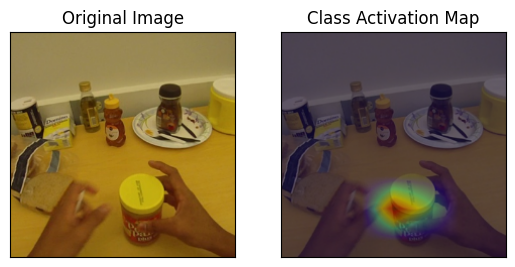

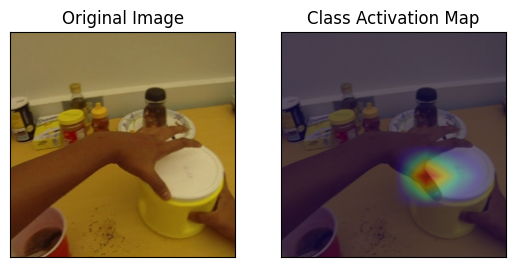

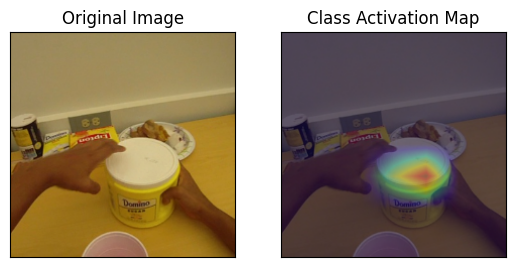

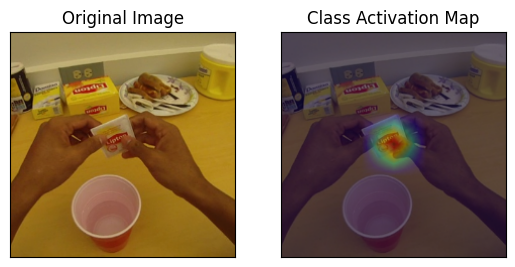

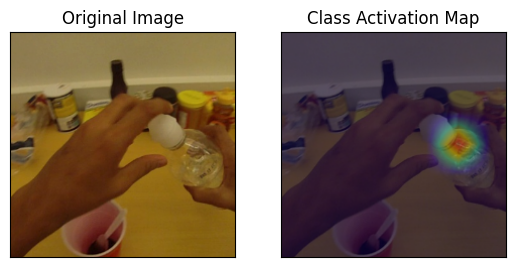

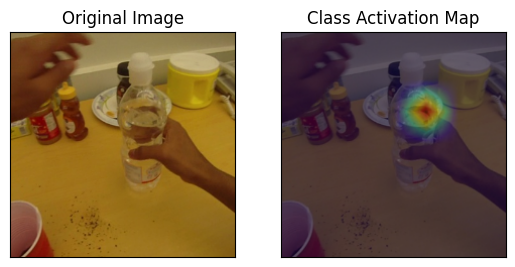

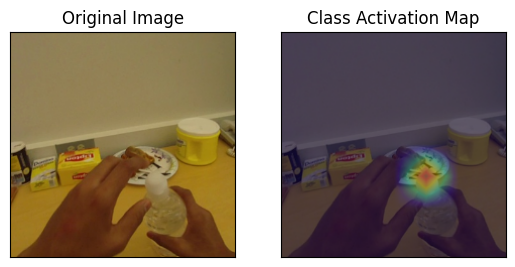

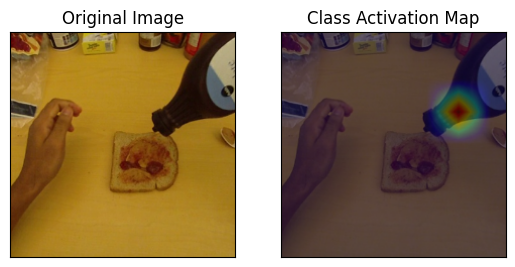

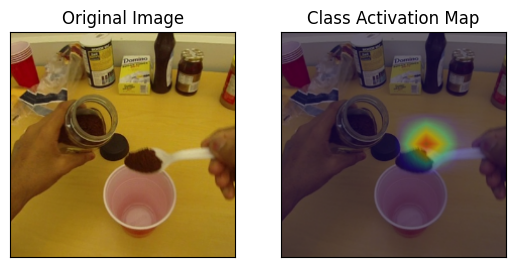

In [22]:
# model.load_state_dict(torch.load('/content/saved_models/homework_step2_c/model'))

for j, (inputs, targets) in enumerate(val_loader):
    inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
    labelVariable = targets.to(DEVICE)
    cam(model, inputVariable, mean, std)